In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def load_data(file_path='data.csv'):

    print(f"Loading data from {file_path}")
    df = pd.read_csv(file_path)
    
    if 'Is Laundering' not in df.columns:
        raise ValueError("The CSV must contain a column named 'Is Laundering'")
    
    y = df['Is Laundering'].astype(int)
    X = df.drop('Is Laundering', axis=1)
    
    categorical_columns = X.select_dtypes(include=['object', 'category']).columns
    if not categorical_columns.empty:
        X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)
    
    print(f"Class distribution:\n{y.value_counts(normalize=True)}")
    
    global MINORITY_CLASS
    MINORITY_CLASS = y.value_counts().idxmin()
    print(f"Minority class (laundering): {MINORITY_CLASS}")
    
    return X, y

file_path = 'D:\Dizertatie\Money_Laundering_project\media\inference\GFP_transactions.csv'
X, y = load_data(file_path)
print(f"Dataset shape: {X.shape}")


X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train_val
)

print(f"Train set: {X_train.shape} - {X_train.shape[0]/X.shape[0]:.1%}")
print(f"Validation set: {X_val.shape} - {X_val.shape[0]/X.shape[0]:.1%}")
print(f"Test set: {X_test.shape} - {X_test.shape[0]/X.shape[0]:.1%}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

Loading data from D:\Dizertatie\Money_Laundering_project\media\inference\GFP_transactions.csv
Class distribution:
Is Laundering
0    0.998981
1    0.001019
Name: proportion, dtype: float64
Minority class (laundering): 1
Dataset shape: (5078345, 99)
Train set: (3047007, 99) - 60.0%
Validation set: (1015669, 99) - 20.0%
Test set: (1015669, 99) - 20.0%


In [3]:
def minority_f1(y_true, y_pred):

    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    f1 = f1_score(y_true, y_pred_binary, pos_label=MINORITY_CLASS)
    return f1

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'verbosity': 0,
        'seed': RANDOM_STATE,
        
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 10**(-2.5), 10**(-1), log=True),
        'lambda': trial.suggest_float('lambda', 10**(-2), 10**(2), log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    
    num_round = trial.suggest_int('num_round', 10, 1000, log=True)
    
    model = xgb.train(
        params,
        dtrain,
        num_round,
        evals=[(dval, "validation")],
        verbose_eval=False
    )
    

    y_pred_proba = model.predict(dval)
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)
    
    validation_f1 = f1_score(y_val, y_pred, pos_label=MINORITY_CLASS)
    
    return -validation_f1

In [4]:
pruner = optuna.pruners.SuccessiveHalvingPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial
print(f"  Value (Negative F1): {trial.value:.4f}")
print(f"  Minority Class F1: {-trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-03-30 13:58:37,957] A new study created in memory with name: no-name-e47da2a5-96e0-4487-afba-4c29f521281f
[I 2025-03-30 13:58:46,686] Trial 0 finished with value: -0.0 and parameters: {'max_depth': 7, 'learning_rate': 0.005891843549686588, 'lambda': 0.27321187248528406, 'scale_pos_weight': 9.908755066013372, 'colsample_bytree': 0.9656830997093353, 'subsample': 0.633942424481871, 'num_round': 17}. Best is trial 0 with value: -0.0.
[I 2025-03-30 13:59:37,409] Trial 1 finished with value: -0.3764523625096824 and parameters: {'max_depth': 14, 'learning_rate': 0.0048700424071591, 'lambda': 0.10832992452931724, 'scale_pos_weight': 5.759084131992572, 'colsample_bytree': 0.910732487549365, 'subsample': 0.7963978275413334, 'num_round': 175}. Best is trial 1 with value: -0.3764523625096824.
[I 2025-03-30 13:59:51,180] Trial 2 finished with value: -0.5654205607476636 and parameters: {'max_depth': 11, 'learning_rate': 0.07416308049463599, 'lambda': 5.025651827471004, 'scale_pos_weight': 8.

Best trial:
  Value (Negative F1): -0.6105
  Minority Class F1: 0.6105
  Params:
    max_depth: 7
    learning_rate: 0.027767106691963472
    lambda: 0.08108301668277595
    scale_pos_weight: 6.710705994948692
    colsample_bytree: 0.7405695219739028
    subsample: 0.8874337790131545
    num_round: 881


<Figure size 1000x600 with 0 Axes>

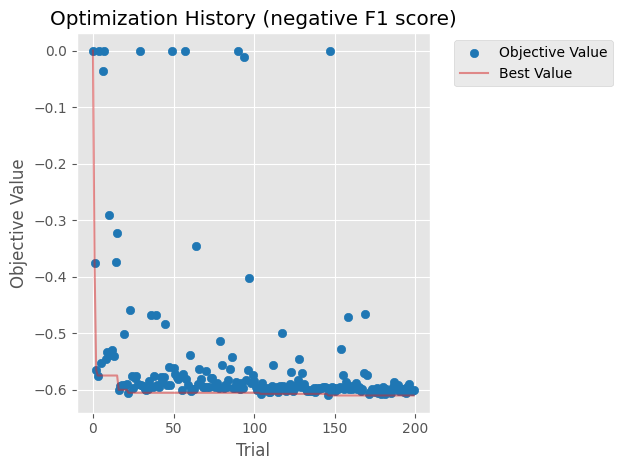

In [5]:
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title('Optimization History (negative F1 score)')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

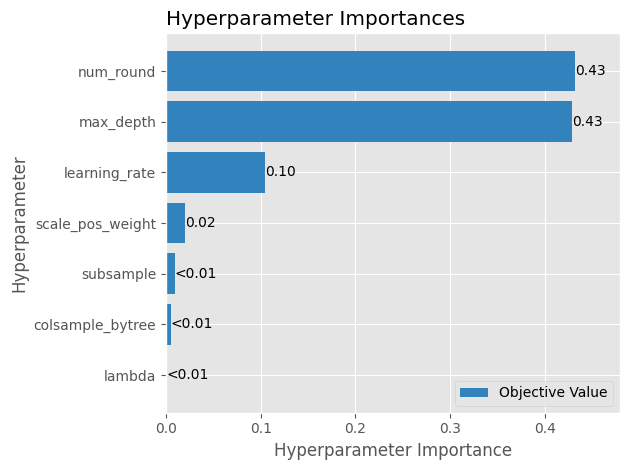

In [6]:
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_param_importances(study)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

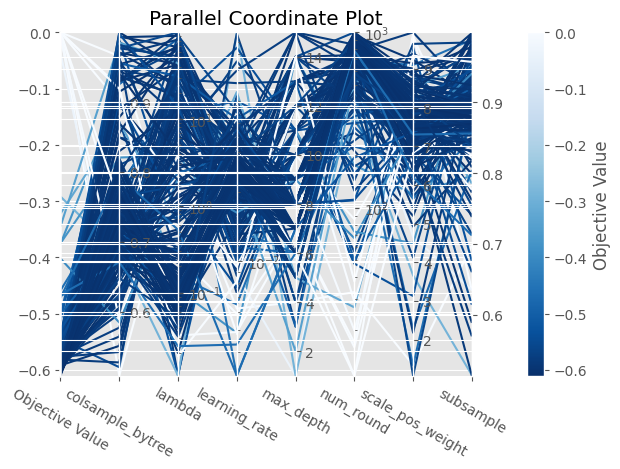

In [7]:
plt.figure(figsize=(12, 8))
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.tight_layout()
plt.show()

In [8]:
best_params = study.best_params.copy()
num_round = best_params.pop('num_round')

In [9]:
best_params = study.best_params.copy()
num_round = best_params.pop('num_round')
best_model = xgb.train(
    best_params,
    dtrain,
    num_round,
    evals=[(dtrain, "train"), (dval, "validation")],
    verbose_eval=100
)

y_pred_proba = best_model.predict(dtest)
thresholds = np.arange(0.1, 0.9, 0.1)
best_f1 = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred = np.where(y_pred_proba > threshold, 1, 0)
    f1 = f1_score(y_test, y_pred, pos_label=MINORITY_CLASS)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.2f}")

y_pred = np.where(y_pred_proba > best_threshold, 1, 0)
test_f1 = f1_score(y_test, y_pred, pos_label=MINORITY_CLASS)

print(f"Test Minority Class F1 Score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[0]	train-rmse:0.03215	validation-rmse:0.03217
[100]	train-rmse:0.02758	validation-rmse:0.02873
[200]	train-rmse:0.02722	validation-rmse:0.02898
[300]	train-rmse:0.02649	validation-rmse:0.02878
[400]	train-rmse:0.02579	validation-rmse:0.02859
[500]	train-rmse:0.02520	validation-rmse:0.02845
[600]	train-rmse:0.02462	validation-rmse:0.02833
[700]	train-rmse:0.02407	validation-rmse:0.02822
[800]	train-rmse:0.02353	validation-rmse:0.02812
[880]	train-rmse:0.02313	validation-rmse:0.02807
Best threshold: 0.40
Test Minority Class F1 Score: 0.5732

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1014634
           1       0.71      0.48      0.57      1035

    accuracy                           1.00   1015669
   macro avg       0.85      0.74      0.79   1015669
weighted avg       1.00      1.00      1.00   1015669



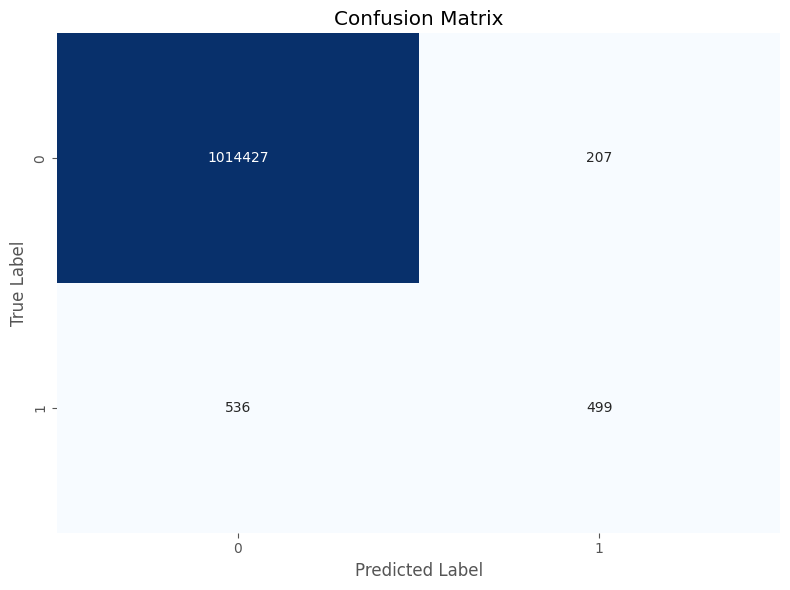

In [10]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

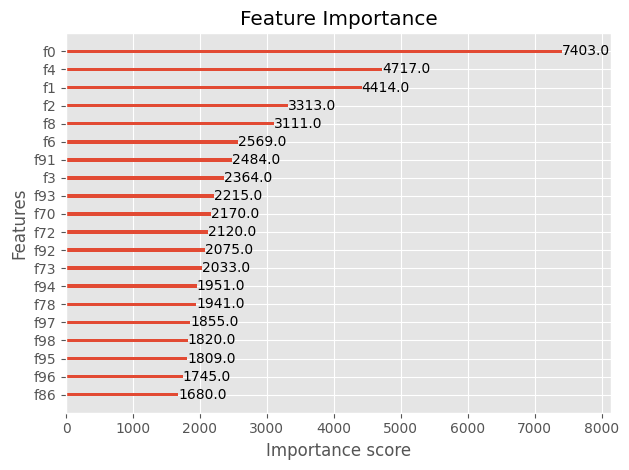

In [11]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(best_model, max_num_features=20)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [ ]:
def get_label_mapping(string_df, encoded_df, string_column, encoded_column, method='frequency'):
    """
    Creates a dictionary mapping from string values to their corresponding label encodings.
    
    Parameters:
    ----------
    string_df : pandas.DataFrame
        DataFrame containing the string values
    encoded_df : pandas.DataFrame
        DataFrame containing the encoded values
    string_column : str
        Name of the column in string_df containing the string values
    encoded_column : str
        Name of the column in encoded_df containing the encoded values
    method : str, optional
        Method to use for mapping:
        - 'frequency': Maps based on matching frequency distributions
        - 'alphabetical': Maps based on alphabetical ordering
    
    Returns:
    -------
    dict
        A dictionary mapping string values to their corresponding encoded values
    """
    string_value_counts = string_df[string_column].value_counts()
    encoded_value_counts = encoded_df[encoded_column].value_counts()
    
    if len(string_value_counts) != len(encoded_value_counts):
        raise ValueError("The number of unique values in both columns must be the same")
    
    mapping = {}
    
    if method == 'frequency':
        string_sorted = string_value_counts.sort_values(ascending=False).index
        encoded_sorted = encoded_value_counts.sort_values(ascending=False).index
        
        # Create mapping based on frequency rank
        for s, e in zip(string_sorted, encoded_sorted):
            mapping[s] = e
    
    elif method == 'alphabetical':
        string_sorted = sorted(string_value_counts.index)
        encoded_sorted = sorted(encoded_value_counts.index)
        
        for s, e in zip(string_sorted, encoded_sorted):
            mapping[s] = e
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return mapping

In [29]:
import pandas as pd
df_strings = pd.read_csv('D:\\Dizertatie\\Money_Laundering_project\\media\\inference\\HI-Small_Trans.csv')
df_encoded = pd.read_csv('D:\\Dizertatie\\Money_Laundering_project\\media\\inference\\formatted_transactions.csv')



In [14]:
print(df_strings.columns.tolist())

['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


In [45]:
# Create mapping
mapping = get_label_mapping(
    string_df=df_strings,
    encoded_df=df_encoded,
    string_column='Payment Format',
    encoded_column='Payment Format'
)

print(mapping)

{'Cheque': 1, 'Credit Card': 2, 'ACH': 4, 'Cash': 3, 'Reinvestment': 0, 'Wire': 5, 'Bitcoin': 6}


In [ ]:
def analyze_payments_by_laundering(df):
    """
    Count the number of rows grouped by 'Payment format', split by 'Is Laundering' values,
    and calculate the percentage of fraudulent transactions.
    
    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing 'Payment format' and 'Is Laundering' columns
    
    Returns:
    -------
    pandas.DataFrame
        DataFrame with counts and percentages for each payment format
    """
    grouped = df.groupby(['Payment Format', 'Is Laundering']).size().unstack(fill_value=0)
    
    for col in [0, 1]:
        if col not in grouped.columns:
            grouped[col] = 0
    
    result = grouped[[0, 1]].rename(columns={0: 'Not Laundering', 1: 'Laundering'})
    
    result['Total'] = result['Not Laundering'] + result['Laundering']
    
    result['Fraud Percentage'] = (result['Laundering'] / result['Total'] * 100).round(2)
    
    return result

In [44]:
result = analyze_payments_by_laundering(df_strings)
print(result)

Is Laundering   Not Laundering  Laundering    Total  Fraud Percentage
Payment Format                                                       
ACH                     596314        4483   600797              0.75
Bitcoin                 146035          56   146091              0.04
Cash                    490783         108   490891              0.02
Cheque                 1864007         324  1864331              0.02
Credit Card            1323118         206  1323324              0.02
Reinvestment            481056           0   481056              0.00
Wire                    171855           0   171855              0.00


In [ ]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
def plot_feature_distributions(df, highlight_id=None, figsize=(14, 12), 
                                                    sample_size=1000000):

    features = ['Payment Format', 'source_fan_out', 'EdgeID', 'source_ratio_out', 
                'source_sum_col3_out', 'dest_ratio_in', 'Amount Sent', 'Amount Received',
                'source_kurtosis_col3_in']

    n_features = len(features)
    
    n_rows = min(3, (n_features + 2) // 3)
    n_cols = min(3, n_features)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows * n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    if len(df) > sample_size:
        highlight_row = None
        if highlight_id is not None and highlight_id in df.index:
            highlight_row = df.loc[[highlight_id]]
        
        sampled_df = df.sample(sample_size, random_state=42)
        
        if highlight_id is not None and highlight_id not in sampled_df.index and highlight_row is not None:
            sampled_df = pd.concat([sampled_df, highlight_row])
        
        plotting_df = sampled_df
    else:
        plotting_df = df
    
    for i, feature in enumerate(features):
        if i >= len(axes):
            break
            
        ax = axes[i]
        
        try:
            series = plotting_df[feature].copy()
            
            series = series.astype('float32')
    
            
            ax.hist(series, bins=30, alpha=0.6, color='skyblue', density=True)
            
            if len(series) > 0:
                kde_x = np.linspace(series.min(), series.max(), 1000000)
                kde = sns.kdeplot(x=series, ax=ax, color='navy', linewidth=2)
            
            ax.set_title(feature)
            ax.set_xlabel('Value')
            ax.set_ylabel('Density')
            
            mean_val = series.mean()
            median_val = series.median()
            ax.axvline(x=mean_val, color='blue', linestyle='--', 
                      label=f'Mean: {float(mean_val):.2f}')
            ax.axvline(x=median_val, color='green', linestyle='--', 
                      label=f'Median: {float(median_val):.2f}')
            
            if highlight_id is not None and highlight_id in plotting_df.index:
                id_value = plotting_df.loc[highlight_id, feature]
                ax.axvline(x=id_value, color='red', linestyle='-', 
                          label=f'ID {highlight_id}: {float(id_value):.2f}')
                
                y_pos = ax.get_ylim()[1] * 0.9
                ax.annotate(f'ID {highlight_id}', 
                            xy=(id_value, y_pos * 0.6),
                            xytext=(id_value, y_pos),
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                            ha='center', fontweight='bold')
            
            ax.legend(fontsize='small')
            
            del series
            gc.collect()
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error plotting {feature}:\n{str(e)}", 
                   ha='center', va='center', transform=ax.transAxes)
    
    for i in range(len(features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    return fig, axes


In [8]:
import pandas as pd
df=pd.read_csv('D:\\Dizertatie\\Money_Laundering_project\\media\\inference\\GFP_transactions.csv')
highlight_id=298998

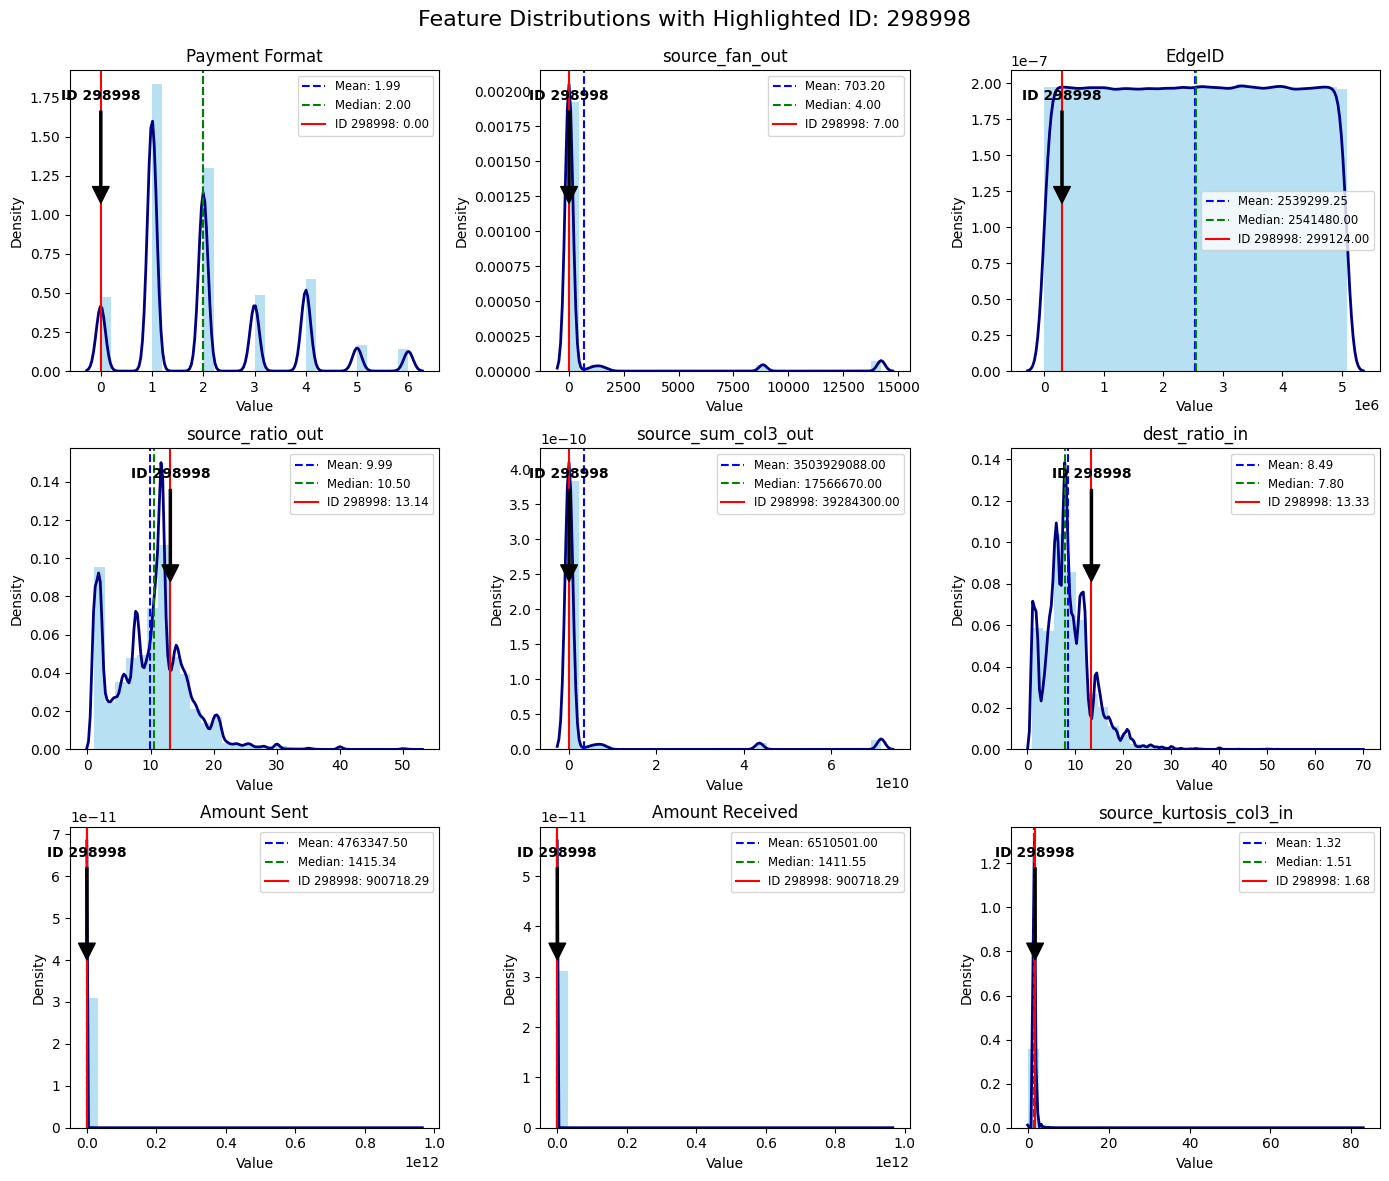

In [ ]:
fig, axes = plot_feature_distributions(df, highlight_id=highlight_id)
plt.suptitle(f'Feature Distributions with Highlighted ID: {highlight_id}', fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()